In [1]:
pip install nflfastpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nflfastpy as nfl
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

pd.set_option('display.max_columns', 7)

In [3]:
data = pd.concat([nfl.load_pbp_data(season).assign(season=season) for season in range(1999, 2021)])

In [4]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

In [21]:
# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.tail()

,team,season,week,...,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
11177,WAS,2020,14,...,-0.044324,-0.050654,-0.012192
11178,WAS,2020,15,...,-0.492323,-0.130957,-0.066140
11179,WAS,2020,16,...,-0.212840,-0.145845,-0.075472
11180,WAS,2020,17,...,-0.239111,-0.162802,-0.086401
11181,WAS,2020,18,...,-0.456388,-0.216182,-0.118524


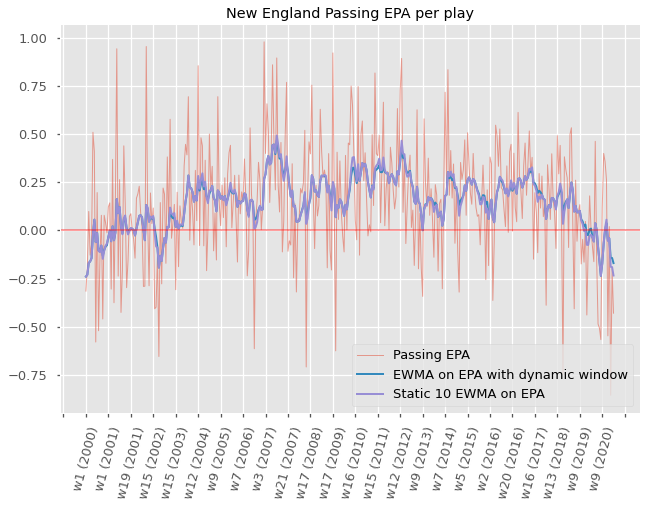

In [23]:
tm = epa.loc[epa['team'] == 'NE', :].assign(
    season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
).set_index('season_week')

fig, ax = plt.subplots()

loc = plticker.MultipleLocator(base=16) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', rotation=75) #rotate the x-axis labels a bit

ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
ax.plot(tm['ewma_passing_offense'], lw=2);
plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)

ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
ax.set_title('New England Passing EPA per play')
plt.show();

In [10]:
schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
.drop_duplicates().reset_index(drop=True)\
.assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))

df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'])\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

df.head()

,season,week,home_team,...,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2000,1,NYG,...,0.269840,0.115978,0.115978
1,2000,1,PIT,...,-0.314740,-0.201637,-0.201637
2,2000,1,WAS,...,-0.368611,0.001226,0.001226
3,2000,1,MIN,...,0.365886,0.105317,0.105317
4,2000,1,LA,...,-0.078273,-0.086851,-0.086851


In [11]:
target = 'home_team_win'
features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
for feature in features:
  print(feature)

ewma_dynamic_window_rushing_offense_home
ewma_dynamic_window_passing_offense_home
ewma_dynamic_window_rushing_defense_home
ewma_dynamic_window_passing_defense_home
ewma_dynamic_window_rushing_offense_away
ewma_dynamic_window_passing_offense_away
ewma_dynamic_window_rushing_defense_away
ewma_dynamic_window_passing_defense_away


In [12]:
df = df.dropna()

X = df.loc[df['season'] != 2020, features].values
y = df.loc[df['season'] != 2020, target].values

clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [13]:
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))

Model Accuracy: 0.633718560002257


In [14]:
print('Neg log loss:', np.mean(log_losses))

Neg log loss: -0.6383735341002166


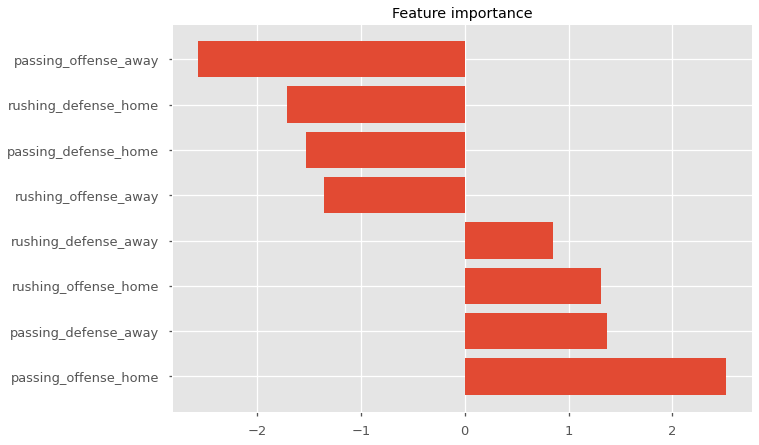

In [15]:
ig, ax = plt.subplots()

feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x:x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title('Feature importance')

ax.barh(features_sorted, coef_sorted);
plt.show();

In [19]:
df_2020 = df.loc[(df['season'] == 2020)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)\
[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df_2020['actual_winner'] = df_2020.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df_2020['predicted_winner'] = df_2020.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_2020['win_probability'] = df_2020.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df_2020['correct_prediction'] = (df_2020['predicted_winner'] == df_2020['actual_winner']).astype(int)

df_2020 = df_2020.drop(columns=['home_team_win_probability', 'home_team_win'])

df_2020.sort_values(by='win_probability', ascending=False).reset_index(drop=True)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,KC,NYJ,8,KC,KC,0.874632,1
1,KC,DEN,13,KC,KC,0.847304,1
2,LA,NYJ,15,LA,NYJ,0.832521,0
3,LA,NYG,4,LA,LA,0.832395,1
4,SF,PHI,4,SF,PHI,0.818946,0
...,...,...,...,...,...,...,...
264,BUF,LA,3,LA,BUF,0.503445,0
265,CAR,ATL,8,ATL,ATL,0.503134,1
266,SEA,ARI,11,SEA,SEA,0.501779,1
267,LA,DAL,1,LA,LA,0.501490,1


In [20]:
correct = df_2020.loc[df_2020['correct_prediction'] == 1].groupby('week')['correct_prediction'].sum()

num_games = df_2020.groupby('week')['correct_prediction'].size()

results = correct / num_games

results

week
1     0.750000
2     0.875000
3     0.500000
4     0.733333
5     0.714286
6     0.571429
7     0.714286
8     0.571429
9     0.500000
10    0.785714
11    0.714286
12    0.687500
13    0.466667
14    0.562500
15    0.687500
16    0.687500
17    0.750000
18    0.666667
19    0.750000
20    0.500000
21    1.000000
Name: correct_prediction, dtype: float64